In [1]:
import torchvision
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms, datasets

d:\Anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# dataloader
data_dir = "dataset/"

transform_train = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(data_dir,
                           train=True,
                           transform=transform_train,
                           download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=12)
test_dataset = datasets.CIFAR10(data_dir,
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=12)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 对比学习cifar10
from contrastive_learning_dataset import ContrastiveLearningDataset
import torch

contr = ContrastiveLearningDataset("../ssl-attacks-defenses/dataset/")

contr_dataset = contr.get_dataset("cifar10", 2)

contr_loader = torch.utils.data.DataLoader(contr_dataset, batch_size=256, shuffle=True,
                                            num_workers=12, pin_memory=True, drop_last=True)

Files already downloaded and verified


In [6]:
# 定义模型
class resnet_modified(nn.Module):
    def __init__(self, feature_dim):
        super(resnet_modified, self).__init__()
        self.backbone = torchvision.models.resnet18()
        self.backbone.maxpool = nn.Identity()
        self.backbone.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.fc = nn.Linear(512, feature_dim)
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        feature = self.backbone(x)
        cls = self.fc(feature)
        return cls, feature

In [7]:
# 训练参数设置
device = "cuda"
feature_dim = 1024
num_epoch = 128


In [8]:
# 监督训练
import torch.nn.functional as F

model = resnet_modified(feature_dim=feature_dim)
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0008)
criterion = nn.CrossEntropyLoss()

state_dict = model.state_dict()
checkpoint_name = f'model_weights_0_{feature_dim}.pth.tar'
torch.save(model.state_dict(), checkpoint_name)

for epoch in range(num_epoch):
    train_loss = []
    train_accs = []
    for batch, labels in tqdm(train_loader):
        batch = batch.to(device)
        labels = labels.to(device)
        logits = F.softmax(model(batch)[0],dim=1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{num_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    if epoch in [1, 3, 7, 15, 31, 63, 127]:
        state_dict = model.state_dict()
        checkpoint_name = f'model_weights_{epoch+1}_{feature_dim}.pth.tar'
        torch.save(model.state_dict(), checkpoint_name)

 46%|████▌     | 90/196 [00:57<01:07,  1.57it/s] 


KeyboardInterrupt: 

In [6]:
# 无监督 VICReg
from tqdm import tqdm

model = resnet_modified(feature_dim=128, pretrain=False)
model.to(device)
model.train()

relu = nn.ReLU()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0008)
criterion_invariance = nn.MSELoss()

for epoch in range(num_epoch):
    train_loss = []
    for batchs, _ in tqdm(contr_loader):
        batch1 = batchs[0].to(device)
        batch2 = batchs[1].to(device)
        features1 = model(batch1)[1]
        features2 = model(batch2)[1]
        
        # invariance loss
        loss_invariance = criterion_invariance(features1, features2)
        # variance loss
        std_features1 = torch.sqrt(features1.var(dim=0) + 1e-04)
        std_features2 = torch.sqrt(features2.var(dim=0) + 1e-04)
        loss_variance = torch.mean(relu(1 - std_features1)) + torch.mean(relu(1 - std_features2))
        # covariance loss
        features1 = features1 - features1.mean(dim=0)
        features2 = features2 - features2.mean(dim=0)
        cov_features1 = (features1.T @ features1) / (256 - 1)
        cov_features2 = (features2.T @ features2) / (256 - 1)
        diag1 = torch.diag(cov_features1)
        cov_features1_diag = torch.diag_embed(diag1)
        cov_features1_nondiag = cov_features1 - cov_features1_diag
        diag2 = torch.diag(cov_features2)
        cov_features2_diag = torch.diag_embed(diag2)
        cov_features2_nondiag = cov_features2 - cov_features2_diag
        loss_covariance = cov_features1_nondiag.pow_(2).sum() / 512 + cov_features2_nondiag.pow_(2).sum() / 512
        
        loss = 25 * loss_invariance + 25 * loss_variance + 1 * loss_covariance
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    print(f"[ Train | {epoch + 1:03d}/{num_epoch:03d} ] loss = {train_loss:.5f}")
    
    if epoch in [1, 3, 7, 15, 31, 63, 127]:
        state_dict = model.state_dict()
        if pretrain:
            checkpoint_name = f'contr_model_weights{epoch+1}_{feature_dim}_pretrain.pth.tar'
        else:
            checkpoint_name = f'contr_model_weights{epoch+1}_{feature_dim}.pth.tar'
        torch.save(model.state_dict(), checkpoint_name)
    


100%|██████████| 195/195 [00:25<00:00,  7.66it/s]


[ Train | 001/128 ] loss = 37.14067


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 002/128 ] loss = 34.87555


100%|██████████| 195/195 [00:24<00:00,  7.88it/s]


[ Train | 003/128 ] loss = 33.64002


100%|██████████| 195/195 [00:24<00:00,  7.86it/s]


[ Train | 004/128 ] loss = 32.66676


100%|██████████| 195/195 [00:24<00:00,  7.91it/s]


[ Train | 005/128 ] loss = 31.86319


100%|██████████| 195/195 [00:24<00:00,  7.86it/s]


[ Train | 006/128 ] loss = 31.16290


100%|██████████| 195/195 [00:24<00:00,  7.91it/s]


[ Train | 007/128 ] loss = 30.63461


100%|██████████| 195/195 [00:24<00:00,  7.93it/s]


[ Train | 008/128 ] loss = 30.15136


100%|██████████| 195/195 [00:24<00:00,  7.82it/s]


[ Train | 009/128 ] loss = 29.76288


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 010/128 ] loss = 29.36737


100%|██████████| 195/195 [00:24<00:00,  7.90it/s]


[ Train | 011/128 ] loss = 29.07742


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 012/128 ] loss = 28.69971


100%|██████████| 195/195 [00:24<00:00,  7.88it/s]


[ Train | 013/128 ] loss = 28.52037


100%|██████████| 195/195 [00:24<00:00,  7.86it/s]


[ Train | 014/128 ] loss = 28.24004


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 015/128 ] loss = 28.07184


100%|██████████| 195/195 [00:24<00:00,  7.91it/s]


[ Train | 016/128 ] loss = 27.84434


100%|██████████| 195/195 [00:24<00:00,  7.84it/s]


[ Train | 017/128 ] loss = 27.63163


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 018/128 ] loss = 27.46052


100%|██████████| 195/195 [00:24<00:00,  7.83it/s]


[ Train | 019/128 ] loss = 27.29018


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 020/128 ] loss = 27.13271


100%|██████████| 195/195 [00:24<00:00,  7.93it/s]


[ Train | 021/128 ] loss = 27.01474


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 022/128 ] loss = 26.86049


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 023/128 ] loss = 26.66511


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 024/128 ] loss = 26.55435


100%|██████████| 195/195 [00:24<00:00,  7.82it/s]


[ Train | 025/128 ] loss = 26.45498


100%|██████████| 195/195 [00:24<00:00,  7.91it/s]


[ Train | 026/128 ] loss = 26.29888


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 027/128 ] loss = 26.30949


100%|██████████| 195/195 [00:24<00:00,  7.90it/s]


[ Train | 028/128 ] loss = 26.04913


100%|██████████| 195/195 [00:24<00:00,  7.89it/s]


[ Train | 029/128 ] loss = 26.03038


100%|██████████| 195/195 [00:24<00:00,  7.82it/s]


[ Train | 030/128 ] loss = 25.86855


100%|██████████| 195/195 [00:24<00:00,  7.91it/s]


[ Train | 031/128 ] loss = 25.81288


100%|██████████| 195/195 [00:24<00:00,  7.89it/s]


[ Train | 032/128 ] loss = 25.68443


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 033/128 ] loss = 25.52259


100%|██████████| 195/195 [00:24<00:00,  7.88it/s]


[ Train | 034/128 ] loss = 25.54760


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 035/128 ] loss = 25.51114


100%|██████████| 195/195 [00:24<00:00,  7.94it/s]


[ Train | 036/128 ] loss = 25.34179


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 037/128 ] loss = 25.09372


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 038/128 ] loss = 25.21373


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 039/128 ] loss = 25.13480


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 040/128 ] loss = 25.05456


100%|██████████| 195/195 [00:24<00:00,  7.81it/s]


[ Train | 041/128 ] loss = 24.95662


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 042/128 ] loss = 24.92674


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 043/128 ] loss = 24.74464


100%|██████████| 195/195 [00:24<00:00,  7.89it/s]


[ Train | 044/128 ] loss = 24.78720


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 045/128 ] loss = 24.67055


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 046/128 ] loss = 24.60876


100%|██████████| 195/195 [00:24<00:00,  7.93it/s]


[ Train | 047/128 ] loss = 24.59811


100%|██████████| 195/195 [00:24<00:00,  7.90it/s]


[ Train | 048/128 ] loss = 24.45204


100%|██████████| 195/195 [00:25<00:00,  7.79it/s]


[ Train | 049/128 ] loss = 24.41513


100%|██████████| 195/195 [00:24<00:00,  7.93it/s]


[ Train | 050/128 ] loss = 24.34743


100%|██████████| 195/195 [00:24<00:00,  7.85it/s]


[ Train | 051/128 ] loss = 24.28034


100%|██████████| 195/195 [00:24<00:00,  7.92it/s]


[ Train | 052/128 ] loss = 24.28425


100%|██████████| 195/195 [00:25<00:00,  7.62it/s]


[ Train | 053/128 ] loss = 24.23320


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 054/128 ] loss = 24.09638


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 055/128 ] loss = 24.08598


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 056/128 ] loss = 24.07302


100%|██████████| 195/195 [00:36<00:00,  5.39it/s]


[ Train | 057/128 ] loss = 24.03762


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 058/128 ] loss = 24.04648


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 059/128 ] loss = 23.91952


100%|██████████| 195/195 [00:36<00:00,  5.39it/s]


[ Train | 060/128 ] loss = 23.91831


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 061/128 ] loss = 23.77151


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 062/128 ] loss = 23.72012


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 063/128 ] loss = 23.80068


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 064/128 ] loss = 23.69681


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 065/128 ] loss = 23.68205


100%|██████████| 195/195 [00:35<00:00,  5.44it/s]


[ Train | 066/128 ] loss = 23.60061


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 067/128 ] loss = 23.61401


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 068/128 ] loss = 23.55394


100%|██████████| 195/195 [00:39<00:00,  4.91it/s]


[ Train | 069/128 ] loss = 23.50588


100%|██████████| 195/195 [00:47<00:00,  4.13it/s]


[ Train | 070/128 ] loss = 23.38019


100%|██████████| 195/195 [00:47<00:00,  4.11it/s]


[ Train | 071/128 ] loss = 23.37775


100%|██████████| 195/195 [00:47<00:00,  4.10it/s]


[ Train | 072/128 ] loss = 23.37273


100%|██████████| 195/195 [00:47<00:00,  4.10it/s]


[ Train | 073/128 ] loss = 23.35096


100%|██████████| 195/195 [00:47<00:00,  4.10it/s]


[ Train | 074/128 ] loss = 23.20288


100%|██████████| 195/195 [00:47<00:00,  4.09it/s]


[ Train | 075/128 ] loss = 23.30899


100%|██████████| 195/195 [00:47<00:00,  4.11it/s]


[ Train | 076/128 ] loss = 23.21630


100%|██████████| 195/195 [00:47<00:00,  4.12it/s]


[ Train | 077/128 ] loss = 23.22981


100%|██████████| 195/195 [00:47<00:00,  4.11it/s]


[ Train | 078/128 ] loss = 23.24174


100%|██████████| 195/195 [00:47<00:00,  4.12it/s]


[ Train | 079/128 ] loss = 23.10194


100%|██████████| 195/195 [00:47<00:00,  4.10it/s]


[ Train | 080/128 ] loss = 23.21787


100%|██████████| 195/195 [00:47<00:00,  4.12it/s]


[ Train | 081/128 ] loss = 23.11115


100%|██████████| 195/195 [00:47<00:00,  4.12it/s]


[ Train | 082/128 ] loss = 22.94479


100%|██████████| 195/195 [00:43<00:00,  4.44it/s]


[ Train | 083/128 ] loss = 23.06096


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 084/128 ] loss = 22.93013


100%|██████████| 195/195 [00:36<00:00,  5.37it/s]


[ Train | 085/128 ] loss = 23.03122


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 086/128 ] loss = 22.95211


100%|██████████| 195/195 [00:36<00:00,  5.42it/s]


[ Train | 087/128 ] loss = 22.83565


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 088/128 ] loss = 22.82037


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 089/128 ] loss = 22.83530


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 090/128 ] loss = 22.75246


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 091/128 ] loss = 22.81870


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 092/128 ] loss = 22.68771


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 093/128 ] loss = 22.68784


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 094/128 ] loss = 22.70395


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 095/128 ] loss = 22.55923


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 096/128 ] loss = 22.63276


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 097/128 ] loss = 22.49925


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 098/128 ] loss = 22.53984


100%|██████████| 195/195 [00:26<00:00,  7.30it/s]


[ Train | 099/128 ] loss = 22.59625


100%|██████████| 195/195 [00:30<00:00,  6.40it/s]


[ Train | 100/128 ] loss = 22.49792


100%|██████████| 195/195 [00:36<00:00,  5.37it/s]


[ Train | 101/128 ] loss = 22.47508


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 102/128 ] loss = 22.48598


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 103/128 ] loss = 22.41207


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 104/128 ] loss = 22.40481


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 105/128 ] loss = 22.43401


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 106/128 ] loss = 22.38074


100%|██████████| 195/195 [00:36<00:00,  5.42it/s]


[ Train | 107/128 ] loss = 22.31311


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 108/128 ] loss = 22.35249


100%|██████████| 195/195 [00:36<00:00,  5.41it/s]


[ Train | 109/128 ] loss = 22.30808


100%|██████████| 195/195 [00:36<00:00,  5.39it/s]


[ Train | 110/128 ] loss = 22.29471


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 111/128 ] loss = 22.18994


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 112/128 ] loss = 22.17642


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 113/128 ] loss = 22.20886


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 114/128 ] loss = 22.17027


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 115/128 ] loss = 22.21550


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 116/128 ] loss = 22.10811


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 117/128 ] loss = 22.18126


100%|██████████| 195/195 [00:36<00:00,  5.42it/s]


[ Train | 118/128 ] loss = 22.03674


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 119/128 ] loss = 22.16017


100%|██████████| 195/195 [00:36<00:00,  5.38it/s]


[ Train | 120/128 ] loss = 22.07928


100%|██████████| 195/195 [00:35<00:00,  5.43it/s]


[ Train | 121/128 ] loss = 22.11589


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 122/128 ] loss = 22.02642


100%|██████████| 195/195 [00:35<00:00,  5.42it/s]


[ Train | 123/128 ] loss = 22.06826


100%|██████████| 195/195 [00:36<00:00,  5.40it/s]


[ Train | 124/128 ] loss = 22.03444


100%|██████████| 195/195 [00:32<00:00,  5.99it/s]


[ Train | 125/128 ] loss = 22.02709


100%|██████████| 195/195 [00:26<00:00,  7.36it/s]


[ Train | 126/128 ] loss = 21.89768


100%|██████████| 195/195 [00:36<00:00,  5.42it/s]


[ Train | 127/128 ] loss = 21.90991


100%|██████████| 195/195 [00:36<00:00,  5.39it/s]

[ Train | 128/128 ] loss = 21.87208


In [4]:
# 测试参数设置
device = "cuda"

feature_dim = 1024
num_epoch = 128
num_64points = 20 # 64倍，test_dataloader

In [5]:
# 测试，写入特征
import pandas as pd

loaded_model = resnet_modified(feature_dim=feature_dim)
loaded_model.load_state_dict(torch.load(f'model_weights_{num_epoch}_{feature_dim}.pth.tar'))

loaded_model.to(device)
loaded_model.eval()

test_loss = []
test_accs = []
feature_data = pd.DataFrame()
label_data = pd.DataFrame()

n = 0

for batch, labels in tqdm(test_loader):
    n = n+1
    batch = batch.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = loaded_model(batch)[0]
        feature = loaded_model(batch)[1]
        
    rep_dataframe = pd.DataFrame(feature.cpu())
    lab_dataframe = pd.DataFrame(labels.cpu())
    feature_data = feature_data._append(rep_dataframe, ignore_index=True)
    label_data = label_data._append(lab_dataframe, ignore_index=True)
    
    acc = (logits.argmax(dim=-1) == labels).float().mean()
    test_accs.append(acc)
    if n==num_64points:
        break

feature_data.to_csv('feature_data.csv', index=False)
label_data.to_csv('label_data.csv', index=False)
test_acc = sum(test_accs) / len(test_accs)
print(f"[ Test ] acc = {test_acc:.5f}")

RuntimeError: Error(s) in loading state_dict for resnet_modified:
	size mismatch for backbone.fc.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for backbone.fc.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([128, 1024]).

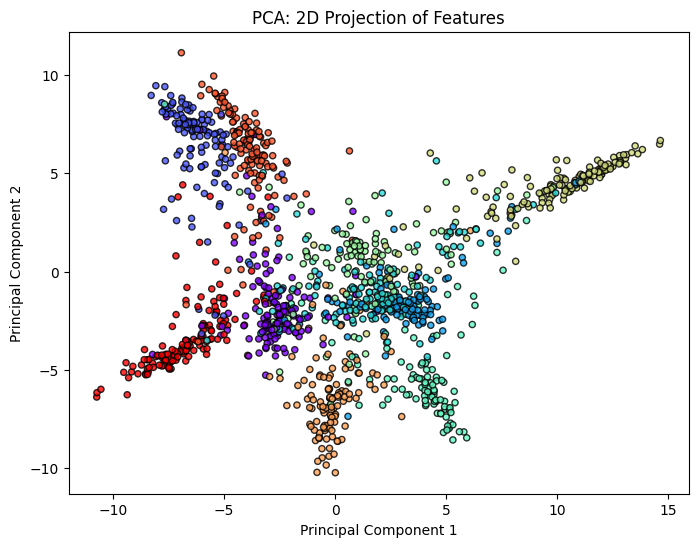

In [8]:
# 2D PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature = feature_data.to_numpy()
labels = label_data.to_numpy()

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(feature)


scaler = StandardScaler()
scaler.fit(feature)
scaled = scaler.transform(feature)

pca = PCA().fit(scaled)

pc = pca.transform(scaled)
pc1 = pc[:,0]
pc2 = pc[:,1]


# 绘制点图
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c=labels, cmap='rainbow', edgecolors='k', alpha=0.8, s=20)
plt.title('PCA: 2D Projection of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

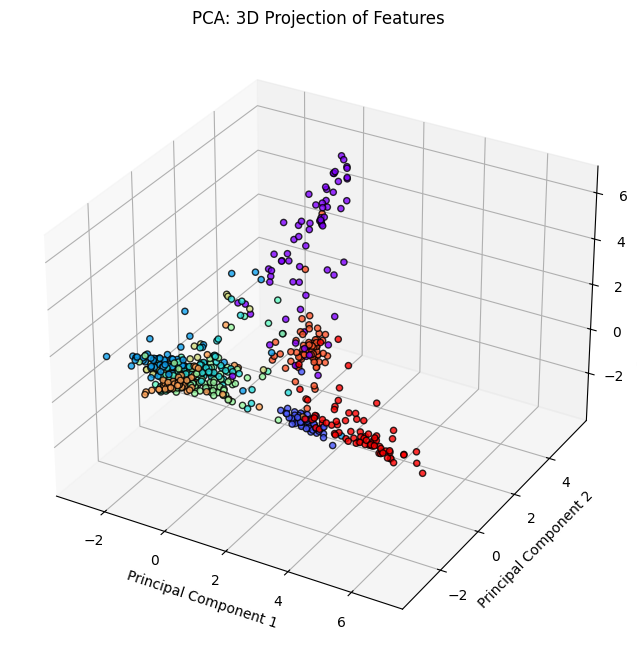

In [ ]:
# 3D PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 用于绘制三维图
from sklearn.decomposition import PCA

feature = feature_data.to_numpy()
labels = label_data.to_numpy()

# 使用PCA进行降维到三维
pca = PCA(n_components=3)
X_pca = pca.fit_transform(feature)

# 绘制三维点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='rainbow', edgecolors='k', s=20, alpha=0.8)

# 设置坐标轴标签
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# 设置图标题
plt.title('PCA: 3D Projection of Features')

# 显示图形
plt.show()

In [1]:
# TSNE
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt

feature = feature_data.to_numpy()
labels = label_data.to_numpy()

tsne = TSNE(n_components=2, learning_rate=200, metric='cosine',n_jobs=-1)
X_tsne = tsne.fit_transform(feature)

# 绘制可视化图表
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='rainbow', edgecolors='k', s=20)
plt.title('t-SNE Visualization of Iris Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()


NameError: name 'feature_data' is not defined